In [2]:
!git clone https://github.com/JialongJiang/DSPIN.git
!pip install anndata
!pip install scanpy
!pip install line_profiler

Cloning into 'DSPIN'...
remote: Enumerating objects: 621, done.
remote: Counting objects: 100% (621/621), done.
remote: Compressing objects: 100% (588/588), done.
remote: Total 621 (delta 44), reused 599 (delta 27), pack-reused 0
Receiving objects: 100% (621/621), 31.01 MiB | 15.52 MiB/s, done.
Resolving deltas: 100% (44/44), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 972.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82808 sha256=950ab84249f0bc78287e015b959ef83d5ca609ec8b084bddeb

In [1]:
import numpy as np
from tqdm import tqdm
import anndata as ad
import sys
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.io import savemat, loadmat
import os
import pandas as pd

## Load data

In [2]:
data_folder = './data/HSC_simulation/'

In [3]:
cadata = ad.read_h5ad(data_folder + 'hsc_simulation_with_perturbations.h5ad')

In [4]:
cadata.var

,gene
0,Cebpa
1,EgrNab
2,Eklf
3,Fli1
4,Fog1
5,Gata1
6,Gata2
7,Gfi1
8,Pu1
9,Scl


In [5]:
gene_list = cadata.var['gene'].values
num_gene = len(gene_list)
samp_list = np.unique(cadata.obs['sample_id'])
aux_ind = [- 1, 0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 3, 4, 5, 6, 7, 8, 9]
samp_name = ['CONTROL'] + [gene + '\nknock-down' for gene in gene_list] + [gene + '\nactivation' for gene in gene_list]
samp_list_name = [samp_name[aux_ind[ii] + 1] for ii in range(num_gene * 2 + 1)]

## Gene Regulatory Network Reconstruction by DSPIN Class

In [6]:
from util.dspin_abstract import DSPIN

/Users/ygong/git/DSPIN-abstract/util/compute.py:653: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [25]:
# Reload the DSPIN class if you have made changes to the util/dspin_abstract.py file

from importlib import reload
import util.dspin_abstract  
reload(util.dspin_abstract)  

<module 'util.dspin_abstract' from '/Users/ygong/git/DSPIN-abstract/util/dspin_abstract.py'>

In [7]:
save_path = 'test/hsc_test0912/'

In [8]:
num_spin = len(cadata.var)

In [9]:
model = DSPIN(cadata, save_path, num_spin=num_spin)

SmallDSPIN initialized.


/Users/ygong/git/DSPIN-abstract/util/dspin_abstract.py:63: UserWarning: num_spin larger than 10 takes long time in Python. Please use computing clusters for larger num_spin.
  warnings.warn("num_spin larger than 10 takes long time in Python. Please use computing clusters for larger num_spin.")


In [10]:
model.network_infer(sample_col_name = 'sample_id')

Progress: 10, Network gradient: 10.819179
Progress: 15, Network gradient: 9.940005
Progress: 20, Network gradient: 4.723530
Progress: 25, Network gradient: 4.415009
Progress: 30, Network gradient: 2.017248
Progress: 35, Network gradient: 1.019174
Progress: 40, Network gradient: 0.897276
Progress: 45, Network gradient: 0.602768
Progress: 50, Network gradient: 0.499034
Progress: 55, Network gradient: 0.295514
Progress: 60, Network gradient: 0.309435
Progress: 65, Network gradient: 0.229778
Progress: 70, Network gradient: 0.221847
Progress: 75, Network gradient: 0.182817
Progress: 80, Network gradient: 0.171078
Progress: 85, Network gradient: 0.151972
Progress: 90, Network gradient: 0.136368
Progress: 95, Network gradient: 0.124465
Progress: 100, Network gradient: 0.112587


In [12]:
cur_j = model.network
cur_h = model.responses

## Visualize simulation of the HSC network with perturbations

In [14]:
from sklearn.cluster import KMeans

kmeans_label = KMeans(n_clusters=7, random_state=0).fit_predict(cadata.X)
cadata.obs['kmeans'] = kmeans_label

/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


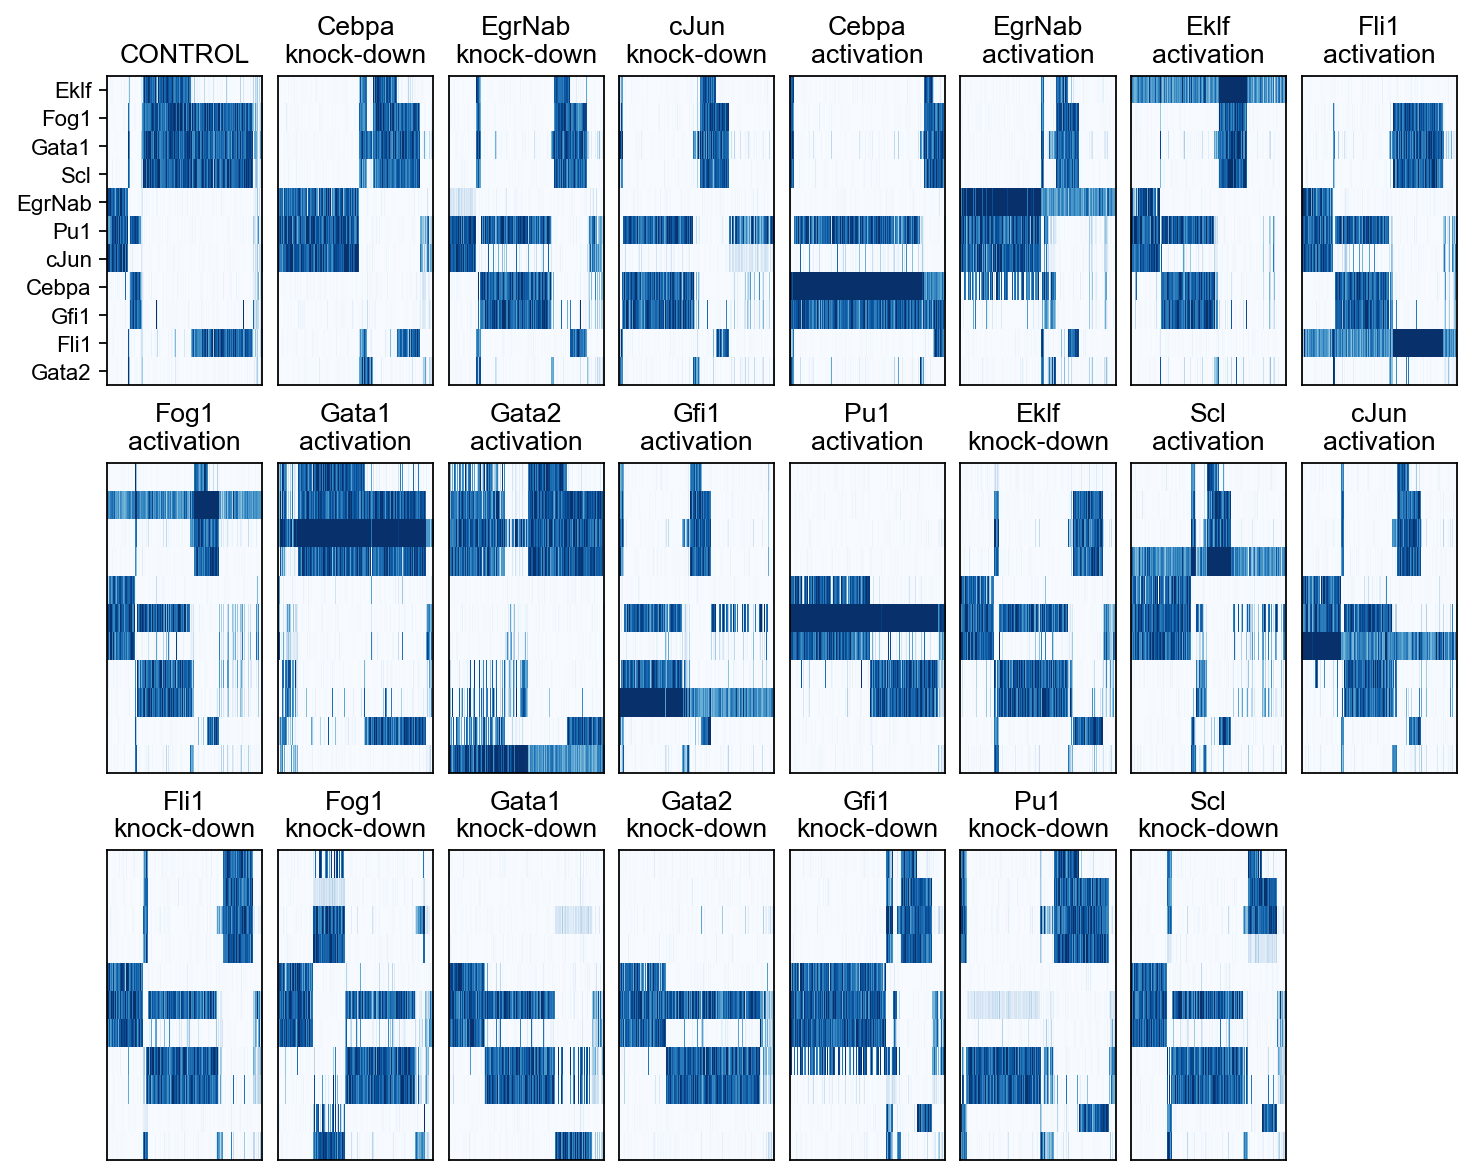

In [15]:
plot_heatmap_sample = samp_list

sc.set_figure_params(figsize=[1.2, 2.7])
fig, grid = sc.pl._tools._panel_grid(0.25, 0.1, ncols=8, num_panels=len(plot_heatmap_sample))
spin_order = np.array([2, 4, 5, 9, 1, 8, 10, 0, 7, 3, 6])

for ii, samp in enumerate(plot_heatmap_sample):
    ax = plt.subplot(grid[ii])
    cur_filt = (cadata.obs['sample_id'] == samp)
    samp_order = np.argsort(cadata.obs['kmeans'][cur_filt])
    plt.imshow(cadata.X[cur_filt, :].T[:, samp_order][spin_order, :], cmap='Blues', aspect='auto', interpolation='none', vmin=0, vmax=2.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(samp_list_name[ii], fontsize=12)

ax = plt.subplot(grid[0])
plt.yticks(np.arange(cadata.shape[1]), cadata.var['gene'][spin_order], fontsize=10)
plt.grid()

## Compare the inferred network with the ground truth

In [16]:
import re

ref_network = pd.read_csv(data_folder + '/refNetwork.csv')

gene_list = cadata.var['gene']
j_mat = np.zeros([len(gene_list), len(gene_list)])

for row in ref_network.itertuples():
    gene1 = row.Gene1
    gene2 = row.Gene2
    interaction = row.Type
    if interaction == '+':
        j_mat[gene_list == gene1, gene_list == gene2] = 1
    elif interaction == '-':
        j_mat[gene_list == gene1, gene_list == gene2] = -1

j_mat[(j_mat == - 1) & (j_mat.T == 1)] = 1
j_mat += j_mat.T
j_mat = np.sign(j_mat)

j_ref = j_mat.copy()

In [17]:
import networkx as nx
import matplotlib.patheffects as patheffects

def plot_jmat_network():

    self_loops = [(u, v) for u, v in G.edges() if u == v]
    G.remove_edges_from(self_loops)

    eposi= [(u, v) for (u,v,d) in G.edges(data=True) if d['weight'] > 0]
    wposi= np.array([d['weight'] for (u,v,d) in G.edges(data=True) if d['weight'] > 0])

    enega = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < 0]
    wnega = np.array([d['weight'] for (u,v,d) in G.edges(data=True) if d['weight'] < 0])

    col1 = '#f0dab1'
    # nx.draw_networkx_nodes(G, pos, ax=ax, node_size=61.8 * nodesz, node_color=col1, edgecolors='None')
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=61.8 * nodesz, node_color=node_color, edgecolors='k')

    sig_fun = lambda xx : (1 / (1 + np.exp(- 5 * (xx + cc))))
    cc = np.max(np.abs(j_mat)) / 10
    # edges
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=eposi, width=linewz * wposi,
                            edge_color='#3285CC', alpha=sig_fun(wposi))

    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=enega, width=- linewz * wnega,
                            edge_color='#E84B23', alpha=sig_fun(- wnega))

    margin = 0.2
    plt.margins(x=0.1, y=0.1)

    ax.set_axis_off()
    ax.set_aspect('equal')
    return ax

Text(0.5, 1.0, 'D-SPIN')

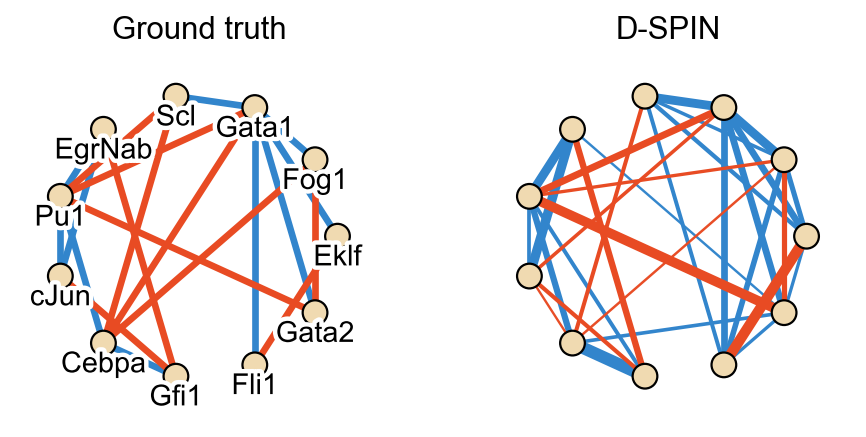

In [18]:
sc.set_figure_params(figsize=[3.2, 3])

nodesz = 2
linewz = 1.5
node_color = ['#f0dab1'] * num_spin
node_label = np.array(list(gene_list[spin_order]))

fig, grid = sc.pl._tools._panel_grid(0.1, 0.1, ncols=2, num_panels=2)

G = nx.from_numpy_array(j_ref[spin_order, :][:, spin_order] * 2)
spin_order = np.array([2, 4, 5, 9, 1, 8, 10, 0, 7, 3, 6])
pos = nx.circular_layout(G)

ax = plt.subplot(grid[0])
ax = plot_jmat_network()

path_effect = [patheffects.withStroke(linewidth=4, foreground='w')]
for ii in range(num_spin):
    text = plt.text(pos[ii][0], pos[ii][1] - 0.15, node_label[ii], fontsize=13, color='k', ha='center', va='center')
    text.set_path_effects(path_effect)
ax.set_title('Ground truth')


ax = plt.subplot(grid[1])
cur_j_filt = cur_j.copy()
cur_j_filt[np.abs(cur_j_filt) < np.percentile(np.abs(cur_j_filt), 40)] = 0
G = nx.from_numpy_array(cur_j_filt[spin_order, :][:, spin_order])
ax = plot_jmat_network()
ax.set_title('D-SPIN')

## Compute accuracy of the inferred network

In [19]:
def precision_recall_curve(j_ref, cur_j):
    num_spin = j_ref.shape[0]
    max_k = int(num_spin * (num_spin - 1) / 2)

    j_ref = np.triu(j_ref, k=1)
    cur_j = np.maximum(np.abs(cur_j), np.abs(cur_j).T)
    cur_j = np.triu(cur_j, k=1)

    # Flatten and sort the upper triangular portions of the matrices
    ref_indices = np.argsort(np.abs(j_ref), axis=None)[::-1]
    cur_indices = np.argsort(np.abs(cur_j), axis=None)[::-1]

    ref_values = np.sort(np.abs(j_ref), axis=None)[::-1]
    cur_values = np.sort(np.abs(cur_j), axis=None)[::-1]

    ref_indices = ref_indices[ref_values > 0]
    cur_indices = cur_indices[cur_values > 0]

    # Compute whether each inferred edge is in the list by order
    edge_in_list = np.isin(cur_indices, ref_indices)
    correct_predictions_cumsum = np.cumsum(edge_in_list)

    precision_values = correct_predictions_cumsum / np.arange(1, max_k+1)
    recall_values = correct_predictions_cumsum / len(ref_indices)

    return precision_values, recall_values

In [20]:
precision, recall = precision_recall_curve(j_ref, cur_j)
print('Top 10 accuracy %.2f , Top 15 accuracy %.2f, Top 20 accuracy %.2f' % (precision[9], precision[14], precision[19]))

Top 10 accuracy 1.00 , Top 15 accuracy 0.93, Top 20 accuracy 0.80
